In [52]:
import numpy as np
from matplotlib import pyplot as plt
import requests
import pandas as pd
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('Carseats.csv')
df['Urban'] = df['Urban'].map({'Yes': 1, 'No': 0})
df['US'] = df['US'].map({'Yes': 1, 'No': 0})
df['ShelveLoc'] = df['ShelveLoc'].map({'Bad': -1, 'Medium': 0, 'Good':1})
high = (df['Sales']>8).astype(int)

df.insert(0, 'High', high, )
#df['High'] = df['High'].map({0:'No', 1:'Yes'})
df.tail()

,High,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
395,1,12.57,138,108,17,203,128,1,33,14,1,1
396,0,6.14,139,23,3,37,120,0,55,11,0,1
397,0,7.41,162,26,12,368,159,0,40,18,1,1
398,0,5.94,100,79,7,284,95,-1,50,12,1,1
399,1,9.71,134,37,0,27,120,1,49,16,1,1


In [3]:
df['ShelveLoc'].unique()

array([-1,  1,  0])

In [3]:
train, val, test = np.split(df.sample(frac=1, random_state=42), 
                                 [int(.6*len(df)), int(.8*len(df))])
train.shape, val.shape, test.shape

h_train, s_train, x_train = np.split(train, [1,2], axis=1)
h_val, s_val, x_val = np.split(val, [1,2], axis=1)
h_test, s_test, x_test = np.split(test, [1,2], axis=1)

b) Arbol que clasifica una variable categorica 'High'

In [157]:
tree = DecisionTreeClassifier(max_depth=6)
tree.fit(x_train, h_train)
print(
        ('Tree depth: {}\nNumber of leaves: {}\nTrain accuracy: {:.3f}'
        '\nValidation accuracy: {:.3f}').format(tree.get_depth(), 
        tree.get_n_leaves(), tree.score(x_train, h_train), 
        tree.score(x_val, h_val))
    )

Tree depth: 6
Number of leaves: 34
Train accuracy: 0.963
Validation accuracy: 0.713


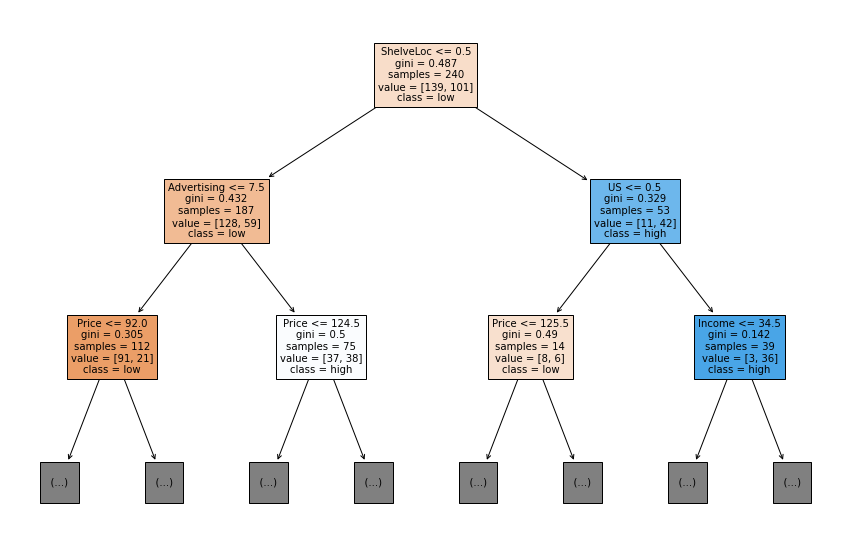

In [159]:
fig = plt.figure(figsize=(15,10))
plot_tree(tree, feature_names=x_train.columns, class_names=['low', 'high'], filled=True, max_depth=2);

c) Ahora un arbol para la variable continua Sales

In [21]:
tree2 = DecisionTreeRegressor(max_depth=3, max_features='sqrt')
tree2.fit(x_train, s_train)
print(
        ('Tree depth: {}\nNumber of leaves: {}\nTrain MSE: {:.2f}'
        '\nValidation MSE: {:.2f}').format(tree2.get_depth(), 
        tree2.get_n_leaves(), mean_squared_error(s_train, tree2.predict(x_train)), 
        mean_squared_error(s_val, tree2.predict(x_val)))
     )


Tree depth: 3
Number of leaves: 8
Train MSE: 4.10
Validation MSE: 6.70


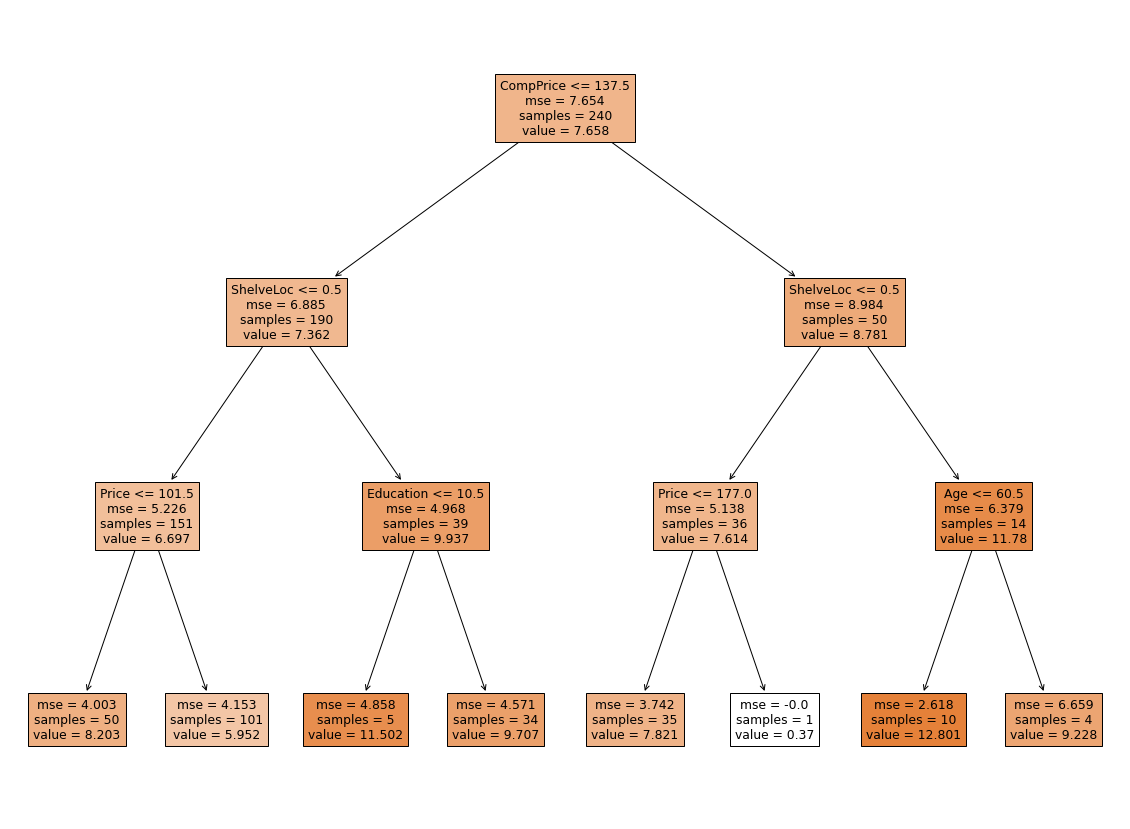

In [22]:
fig = plt.figure(figsize=(20,15))
plot_tree(tree2, feature_names=x_train.columns, filled=True);

e) Cross validation para este ultimo arbol

In [32]:
its = 20

for it in range(its):
    depth = np.random.randint(2, 7)
    alpha = np.random.uniform(0, 0.25)

    tree_cv = DecisionTreeRegressor(max_depth=depth, ccp_alpha=alpha)
    tree_cv.fit(x_train, s_train)
    print(
        ('It {}/{} \tdepth: {}\talpha: {:.2f}\tTrain MSE: {:.2f}'
        ' \tVal MSE: {:.2f}').format(it+1, its, depth, alpha,
        mean_squared_error(s_train, tree_cv.predict(x_train)), 
        mean_squared_error(s_val, tree_cv.predict(x_val)))
        )
    

It 1/20 	depth: 3	alpha: 0.18	Train MSE: 3.25 	Val MSE: 4.64
It 2/20 	depth: 3	alpha: 0.15	Train MSE: 3.25 	Val MSE: 4.64
It 3/20 	depth: 4	alpha: 0.07	Train MSE: 2.37 	Val MSE: 4.34
It 4/20 	depth: 6	alpha: 0.15	Train MSE: 2.86 	Val MSE: 4.39
It 5/20 	depth: 2	alpha: 0.07	Train MSE: 4.37 	Val MSE: 5.07
It 6/20 	depth: 5	alpha: 0.01	Train MSE: 1.50 	Val MSE: 4.60
It 7/20 	depth: 5	alpha: 0.18	Train MSE: 3.03 	Val MSE: 4.46
It 8/20 	depth: 3	alpha: 0.21	Train MSE: 3.25 	Val MSE: 4.64
It 9/20 	depth: 4	alpha: 0.24	Train MSE: 3.25 	Val MSE: 4.64
It 10/20 	depth: 6	alpha: 0.01	Train MSE: 0.88 	Val MSE: 4.58
It 11/20 	depth: 4	alpha: 0.22	Train MSE: 3.03 	Val MSE: 4.46
It 12/20 	depth: 6	alpha: 0.21	Train MSE: 3.03 	Val MSE: 4.46
It 13/20 	depth: 3	alpha: 0.19	Train MSE: 3.25 	Val MSE: 4.64
It 14/20 	depth: 2	alpha: 0.21	Train MSE: 4.37 	Val MSE: 5.07
It 15/20 	depth: 4	alpha: 0.09	Train MSE: 2.52 	Val MSE: 4.35
It 16/20 	depth: 5	alpha: 0.16	Train MSE: 2.86 	Val MSE: 4.39
It 17/20 	depth: 

Vemos que los hiperparametros optimos son depth entre 4 y 5\
y alpha apox. entre .05 y .2

In [99]:
tree_opt = DecisionTreeRegressor(max_depth=4, ccp_alpha=.1)
tree_opt.fit(x_train, s_train)
print('test error: {:.2f}'.format(mean_squared_error(s_test, tree_opt.predict(x_test))))
print('Feature Importance')
for feature, importance in zip(x_train.columns, tree_opt.feature_importances_):
    print(feature, '%.2f' % importance)

test error: 5.70
Feature Importance
CompPrice 0.00
Income 0.00
Advertising 0.15
Population 0.00
Price 0.25
ShelveLoc 0.57
Age 0.03
Education 0.00
Urban 0.00
US 0.00


f) Usemos estadistica de arboles mediante la tecnica de\
bagging para obtener un mejor resultado

In [88]:
n = 500

y_train = s_train.to_numpy(dtype=float).reshape((len(s_train),))
y_val = s_val.to_numpy(dtype=float).reshape((len(s_val),))
y_test = s_test.to_numpy(dtype=float).reshape((len(s_test),))

bag = BaggingRegressor(n_estimators=n, oob_score=True)
bag.fit(x_train, y_train)

print('Train MSE: {:.2}\nVal MSE: {:.2}\nTest MSE: {:.2f}'.format(
    mean_squared_error(y_train, bag.predict(x_train)),
    mean_squared_error(y_val, bag.predict(x_val)),
    mean_squared_error(y_test, bag.predict(x_test))
    )
)


Train MSE: 0.34
Val MSE: 2.7
Test MSE: 2.97


In [101]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in bag.estimators_
], axis=0)

print('Feature importance')
for feature, importance in zip(x_train.columns, feature_importances):
    print(feature, '%.2f' % importance)

Feature importance
CompPrice 0.10
Income 0.05
Advertising 0.09
Population 0.04
Price 0.25
ShelveLoc 0.36
Age 0.07
Education 0.03
Urban 0.01
US 0.01


g) Random forest

In [131]:
n = 100

rf = RandomForestRegressor(n_estimators=n, max_depth=10, max_features='sqrt')
rf.fit(x_train, y_train)

print('Train MSE: {:.2}\nVal MSE: {:.2}\nTest MSE: {:.2f}'.format(
    mean_squared_error(y_train, rf.predict(x_train)),
    mean_squared_error(y_val, rf.predict(x_val)),
    mean_squared_error(y_test, rf.predict(x_test))
    )
)


Train MSE: 0.47
Val MSE: 2.9
Test MSE: 3.69


In [132]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in rf.estimators_
], axis=0)

print('Feature importance')
for feature, importance in zip(x_train.columns, feature_importances):
    print(feature, '%.2f' % importance)

Feature importance
CompPrice 0.10
Income 0.07
Advertising 0.09
Population 0.08
Price 0.22
ShelveLoc 0.28
Age 0.09
Education 0.05
Urban 0.01
US 0.02


h) Por ultimo AdaBoost

In [160]:
n = 2000

ada = AdaBoostRegressor(n_estimators=n, learning_rate=1.25)
ada.fit(x_train, y_train)

print('Train MSE: {:.2}\nVal MSE: {:.2}\nTest MSE: {:.2f}'.format(
    mean_squared_error(y_train, ada.predict(x_train)),
    mean_squared_error(y_val, ada.predict(x_val)),
    mean_squared_error(y_test, ada.predict(x_test))
    )
)

Train MSE: 1.2
Val MSE: 2.4
Test MSE: 3.18


Algunos graficos

In [171]:
bag_err = []
rfs_err = []
rfl_err = []
ada_err = []

for n in range(3,100):
    bag = BaggingRegressor(n_estimators=n, max_samples=.85)
    bag.fit(x_train, y_train)
    bag_err.append(mean_squared_error(y_val, bag.predict(x_val)))

    rfs = RandomForestRegressor(n_estimators=n, max_samples=.85, max_features='sqrt')
    rfs.fit(x_train, y_train)
    rfs_err.append(mean_squared_error(y_val, rfs.predict(x_val)))

    rfl = RandomForestRegressor(n_estimators=n, max_samples=.85, max_features='log2')
    rfl.fit(x_train, y_train)
    rfl_err.append(mean_squared_error(y_val, rfl.predict(x_val)))

    ada = AdaBoostRegressor(n_estimators=n, learning_rate=1.25)
    ada.fit(x_train, y_train)
    ada_err.append(mean_squared_error(y_val, ada.predict(x_val)))



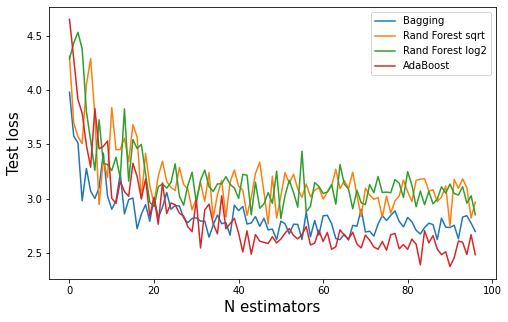

In [172]:
plt.figure(figsize=(8,5))

plt.plot(bag_err, label='Bagging')
plt.plot(rfs_err, label='Rand Forest sqrt')
plt.plot(rfl_err, label='Rand Forest log2')
plt.plot(ada_err, label='AdaBoost')
plt.legend(loc='best')
plt.xlabel('N estimators', fontsize=15)
plt.ylabel('Test loss', fontsize=15);

Igual no confiarse. Con los datos de test bagging es el\
que menos error da. Ademas, aca bagging es mejor que\
random forests, por que?

In [165]:
bag_err = []
rfs_err = []
rfl_err = []
n = 30


for depth in range(1,40):
    bag = RandomForestRegressor(n_estimators=n, max_depth=depth,
                                max_samples=.85, max_features=None)
    bag.fit(x_train, y_train)
    bag_err.append(mean_squared_error(y_test, bag.predict(x_test)))

    rfs = RandomForestRegressor(n_estimators=n, max_depth=depth, 
                                max_samples=.85, max_features='sqrt')
    rfs.fit(x_train, y_train)
    rfs_err.append(mean_squared_error(y_test, rfs.predict(x_test)))

    rfl = RandomForestRegressor(n_estimators=n, max_depth=depth, 
                                max_samples=.85, max_features='log2')
    rfl.fit(x_train, y_train)
    rfl_err.append(mean_squared_error(y_test, rfl.predict(x_test)))

Text(0, 0.5, 'Test loss')

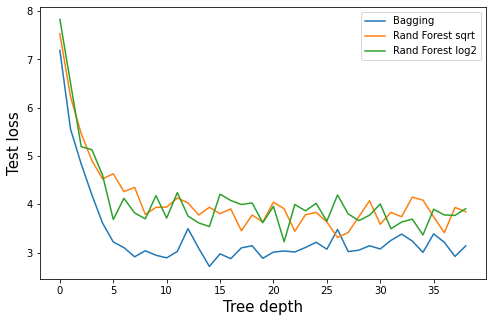

In [166]:
plt.figure(figsize=(8,5))

plt.plot(bag_err, label='Bagging')
plt.plot(rfs_err, label='Rand Forest sqrt')
plt.plot(rfl_err, label='Rand Forest log2')

plt.legend(loc='best')
plt.xlabel('Tree depth', fontsize=15)
plt.ylabel('Test loss', fontsize=15);